# Facial Expression Recognition

This project aims to demonstrate the effectiveness of CNNs and transfer learning in facial expression recognition tasks, showcasing their performance on both static datasets and real-world, dynamic scenarios captured via webcam.

Facial Expression Recognition (FER) is implemented in both a predefined dataset and a real-time scenario using a webcam. The project leverages the FER2013 dataset, sourced from Kaggle, which consists of 28,709 images for training and 7,170 images for testing.
CNN and transfer learning models are implemented and quantified the performance of the models on both the predefined dataset and real-time webcam scenarios.

## Import packages

In [1]:
import tensorflow as tf
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten
from keras.layers import Conv2D,MaxPooling2D
from keras import layers
import random
import matplotlib
matplotlib.use('TkAgg') 
%matplotlib inline

### Checking GPU

In [2]:
tf.config.list_physical_devices('GPU')
# Set the GPU device if available
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU is available.")
else:
    print("No GPU is available, using CPU.")

GPU is available.


## Loading data

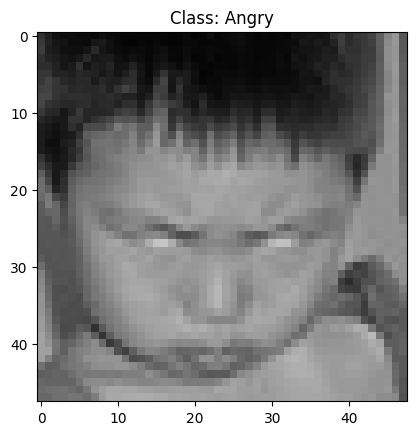

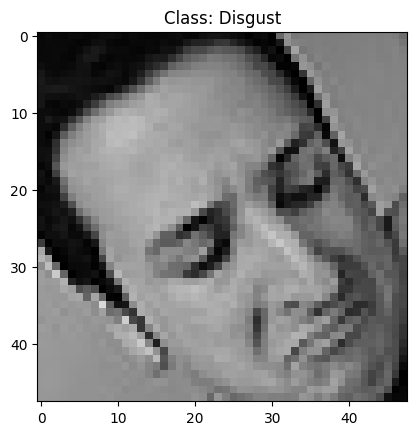

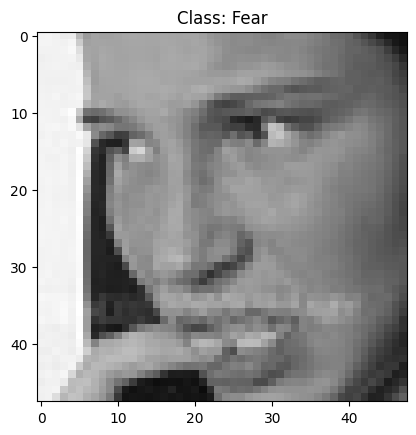

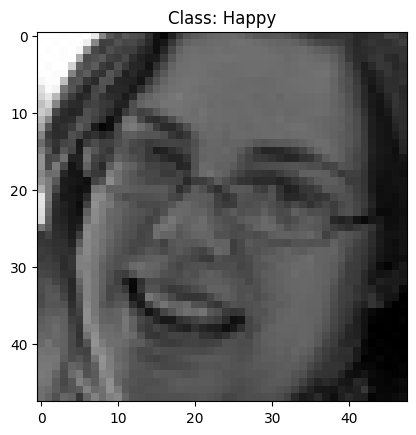

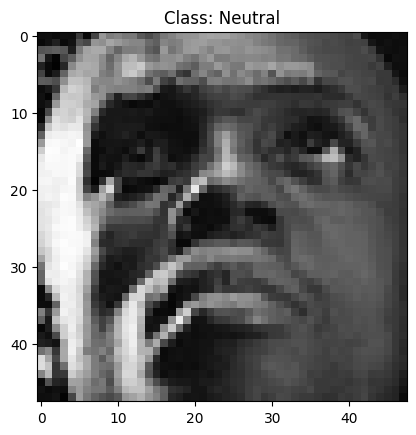

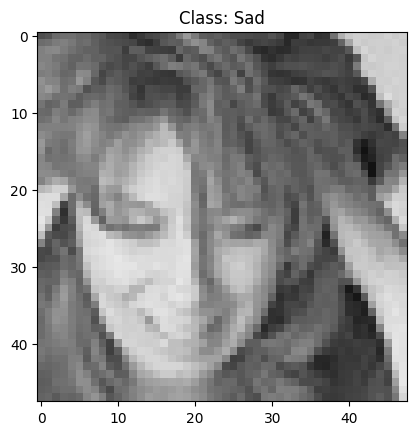

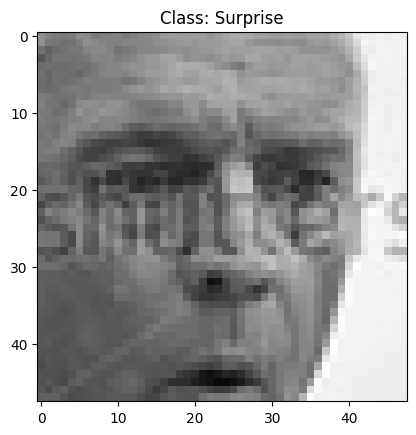

Class Angry: 1 images
Class Disgust: 1 images
Class Fear: 1 images
Class Happy: 1 images
Class Neutral: 1 images
Class Sad: 1 images
Class Surprise: 1 images


In [3]:
train_directory="train"
test_directory="test"
Class=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
class_counts = {}

for category in Class:
    path = os.path.join(train_directory, category)
    class_count = 0
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        img_array = cv2.imread(img_path)
        class_count += 1

        plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
        plt.title(f"Class: {category}")
        plt.show()
        break
    class_counts[category] = class_count


for category, count in class_counts.items():
    print(f"Class {category}: {count} images")


### Preprocessing 

#### Image resizing 

The original FER2013 dataset images are initially provided in a 48x48 resolution. To enhance clarity and compatibility with existing algorithms, particularly for adapting transfer learning applications, these images have been resized uniformly to a standard resolution of 224x224.

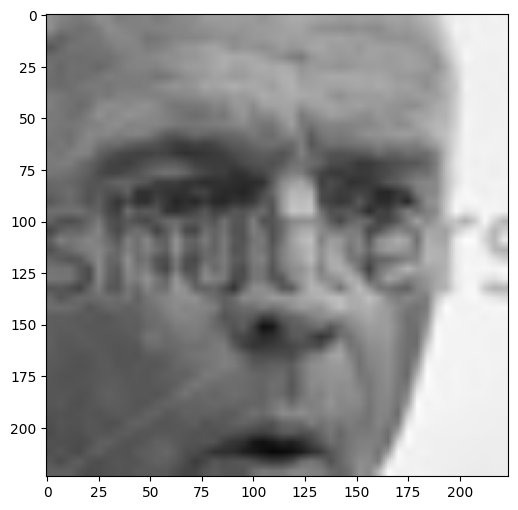

In [4]:
img_size=224 
plt.figure(figsize=(12, 6))
new_array=cv2.resize(img_array, (img_size, img_size))
plt.imshow(cv2.cvtColor(new_array, cv2.COLOR_BGR2RGB))
plt.show()

In [3]:
img_size=(224, 224)
batch_size=32

#### Normalization

The RGB channel values are in the [0, 255] range which will create bias in the model. To normalize RGB values into the range of [0, 1], we need to divide each channel value by 255. This scales the values down to a range where they are more suitable for many machine learning models.

In [4]:
img_size = (224, 224)
batch_size = 32

train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=train_directory,  
    color_mode='grayscale'
    shuffle=True,
    label_mode='categorical',  
    batch_size=batch_size,
    image_size=img_size
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=test_directory,
    color_mode='grayscale'
    label_mode='categorical',
    batch_size=batch_size,
    image_size=img_size
)


SyntaxError: invalid syntax. Perhaps you forgot a comma? (1327498115.py, line 6)

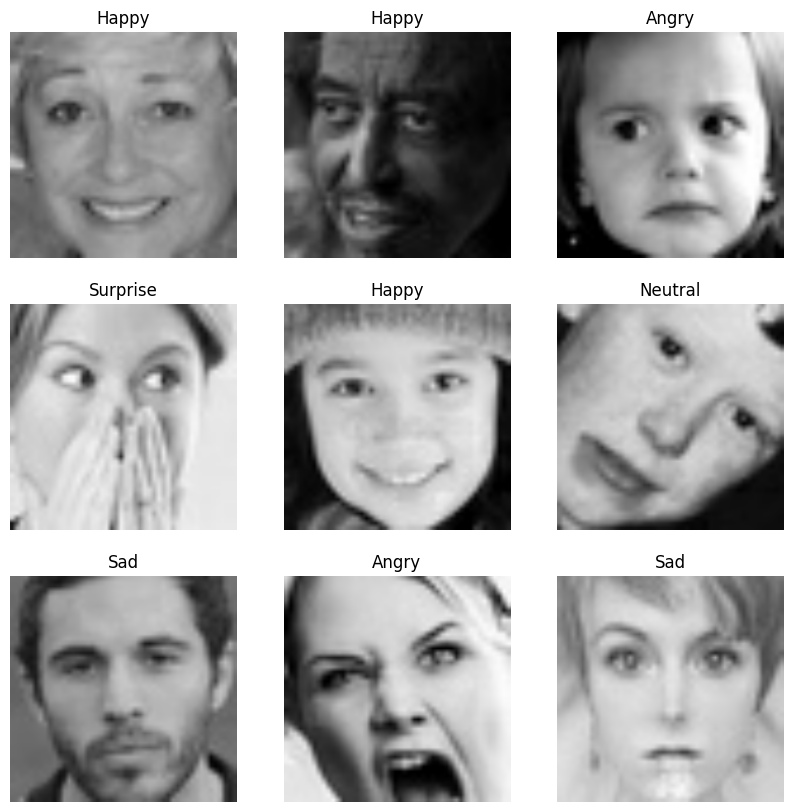

In [5]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Transfer learning 

Let's design the facial expression recognition system on a MobileNet V2 model pre-loaded with weights trained on ImageNet.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


# Create the base model from the pre-trained model MobileNet V2

IMG_SHAPE = img_size + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

### Feature Extraction

In [6]:
# Freeze the base model

base_model.trainable = False
inputs = tf.keras.Input(shape=(224, 224, 3))
X = preprocess_input(inputs)  
base_output = base_model(X, training=False)

### Classification head

In [7]:
# Apply additional layers

Y = layers.GlobalAveragePooling2D()(base_output)
Y = layers.Dense(128, activation='relu')(Y)
Y = layers.Dense(64, activation='relu')(Y)
Y = layers.Dense(7, activation='softmax')(Y)
Y = tf.keras.layers.Dropout(0.2)(Y)
new_model = tf.keras.Model(inputs=inputs, outputs=Y)

print(new_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

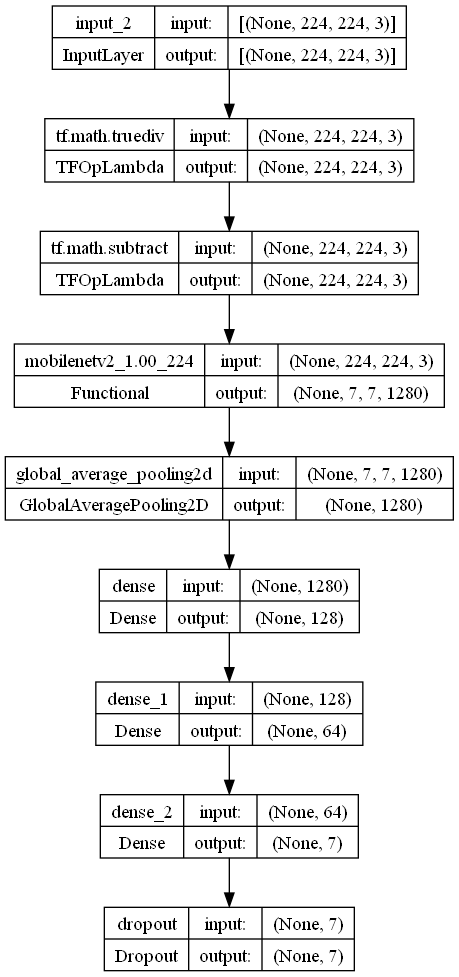

In [11]:
from tensorflow.keras.utils import plot_model
plot_model(new_model, show_shapes=True)


### Compile the model

In [13]:
 new_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')])


### Train the model

In [ ]:
train_path = "train"
test_path = "test"

num_train_imgs = 0
for root, dirs, files in os.walk(train_path):
    num_train_imgs += len(files)
    
num_test_imgs = 0
for root, dirs, files in os.walk(test_path):
    num_test_imgs += len(files)
    
epochs=15

history=new_model.fit(train_dataset,
                steps_per_epoch=num_train_imgs//batch_size,
                epochs=epochs,
                      validation_data=test_dataset,
                validation_steps=num_test_imgs//batch_size)

new_model.save('TransferLearning_model_100epochs.h5')

In [21]:
loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

from keras.models import load_model
from tensorflow.keras.utils import img_to_array

sample_image, _ = next(train_generator)
print(sample_image.shape)


(32, 224, 224, 1)


In [11]:
loss, accuracy = new_model.evaluate(test_generator)


225/225 [==============================] - 11s 47ms/step - loss: 1.4874 - accuracy: 0.4216


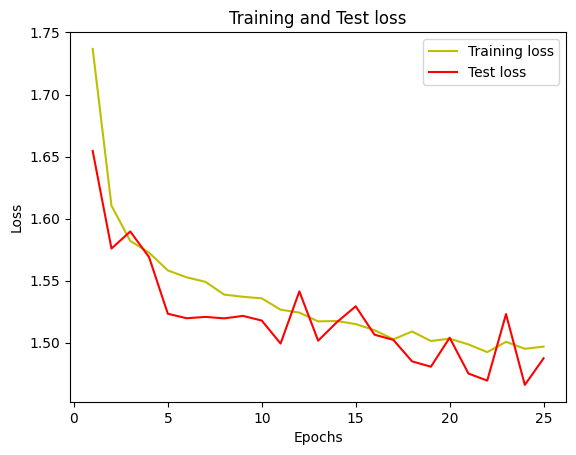

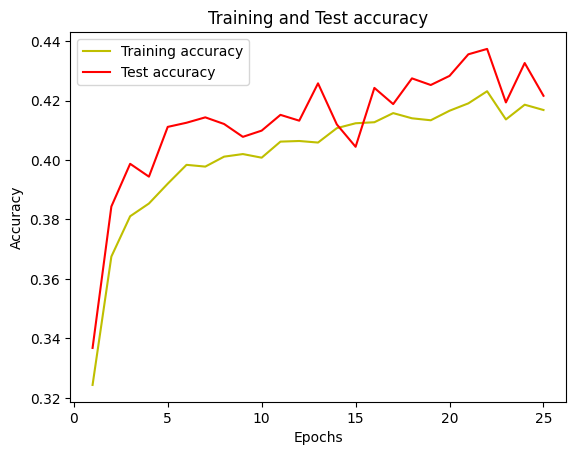

In [23]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Test accuracy')
plt.title('Training and Test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [25]:
from keras.models import load_model

#Test the model
my_model = load_model('emotion_detection_model_100epochs.h5', compile=False)

#Generate a batch of images

test_img, test_lbl = test_generator.__next__()
predictions=my_model.predict(test_img)

predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

from sklearn import metrics
test_labels = np.argmax(test_lbl, axis=1)

1/1 [==============================] - 1s 856ms/step


Text(0.5, 1.0, 'Original label is:Sad Predicted is: Angry')

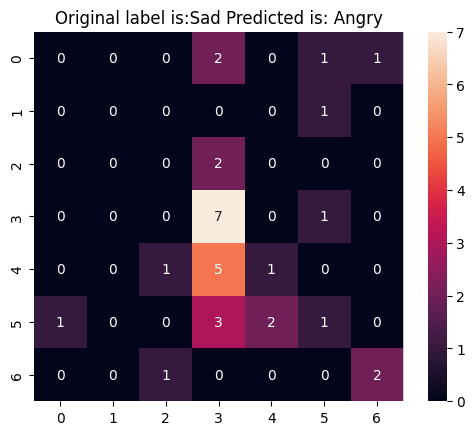

In [26]:
#Confusion Matrix - verify accuracy of each class

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, predictions)


import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']

#Check results on a few select images

n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)

## CNN Model from Scratch

In [7]:
from functools import partial

DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
activation="relu", kernel_initializer="he_normal")

model = tf.keras.Sequential([
DefaultConv2D(filters=32, kernel_size=7, input_shape=[224, 224, 1]),
tf.keras.layers.MaxPool2D(pool_size=(3, 3)),
    
DefaultConv2D(filters=64),
DefaultConv2D(filters=64),
DefaultConv2D(filters=64),
tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
   
DefaultConv2D(filters=128),
DefaultConv2D(filters=128),
DefaultConv2D(filters=128),
tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    
DefaultConv2D(filters=256),   
DefaultConv2D(filters=256),
DefaultConv2D(filters=256),
tf.keras.layers.MaxPool2D(pool_size=(2,2)),
tf.keras.layers.Dropout(0.1)
    
DefaultConv2D(filters=512),
DefaultConv2D(filters=512), 
tf.keras.layers.MaxPool2D(),
tf.keras.layers.Dropout(0.1),
    
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation="relu",
kernel_initializer="he_normal"),
tf.keras.layers.Dropout(0.5),
    
tf.keras.layers.Dense(64, activation="relu",
kernel_initializer="he_normal"),
tf.keras.layers.Dropout(0.5),
    
tf.keras.layers.Dense(7, activation="softmax")
])
    
model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 224, 224, 32)      1600      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_18 (Conv2D)          (None, 74, 74, 64)        18496     
                                                                 
 conv2d_19 (Conv2D)          (None, 74, 74, 64)        36928     
                                                                 
 conv2d_20 (Conv2D)          (None, 74, 74, 64)        36928     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                  

In [7]:
train_path = "train"
test_path = "test"

num_train_imgs = 0
for root, dirs, files in os.walk(train_path):
    num_train_imgs += len(files)
    
num_test_imgs = 0
for root, dirs, files in os.walk(test_path):
    num_test_imgs += len(files)


epochs=500

history=model.fit(train_dataset,
                steps_per_epoch=num_train_imgs//batch_size,
                epochs=epochs,
                validation_data=test_dataset,
                validation_steps=num_test_imgs//batch_size)

model.save('emotion_detection_model_100epochs.h5')

Epoch 1/500
897/897 [==============================] - 142s 150ms/step - loss: 1.8737 - accuracy: 0.2410 - val_loss: 1.8086 - val_accuracy: 0.2485
Epoch 2/500
897/897 [==============================] - 116s 129ms/step - loss: 1.8127 - accuracy: 0.2543 - val_loss: 1.7963 - val_accuracy: 0.2543
Epoch 3/500
897/897 [==============================] - 118s 131ms/step - loss: 1.8009 - accuracy: 0.2541 - val_loss: 1.7810 - val_accuracy: 0.2497
Epoch 4/500
897/897 [==============================] - 126s 140ms/step - loss: 1.7901 - accuracy: 0.2556 - val_loss: 1.7487 - val_accuracy: 0.2672
Epoch 5/500
897/897 [==============================] - 122s 136ms/step - loss: 1.7866 - accuracy: 0.2579 - val_loss: 1.7347 - val_accuracy: 0.2713
Epoch 6/500
897/897 [==============================] - 121s 135ms/step - loss: 1.7576 - accuracy: 0.2688 - val_loss: 1.7096 - val_accuracy: 0.2884
Epoch 7/500
897/897 [==============================] - 123s 137ms/step - loss: 1.7505 - accuracy: 0.2754 - val_loss: 1

In [10]:
loss, accuracy = model.evaluate(test_dataset)

225/225 [==============================] - 10s 43ms/step - loss: 1.0604 - accuracy: 0.6034


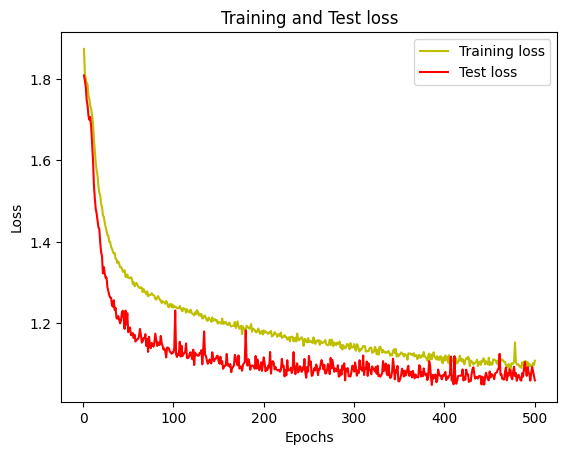

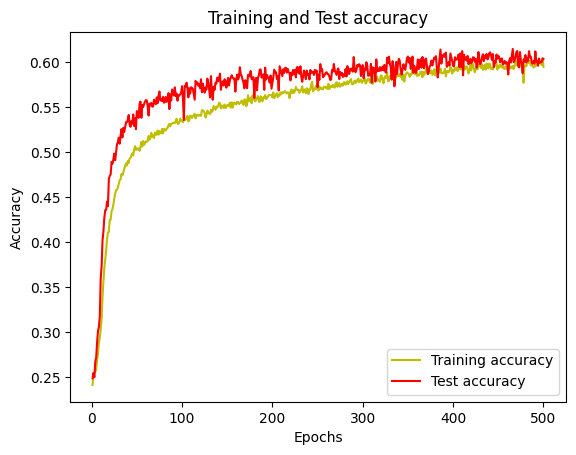

In [11]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Test accuracy')
plt.title('Training and Test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [15]:
from keras.models import load_model
#Test the model
my_model = load_model('emotion_detection_model_100epochs.h5', compile=False)

#Generate a batch of images

test_img, test_lbl = test_dataset.__next__()
predictions=my_model.predict(test_img)

predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

from sklearn import metrics
test_labels = np.argmax(test_lbl, axis=1)



1/1 [==============================] - 0s 115ms/step


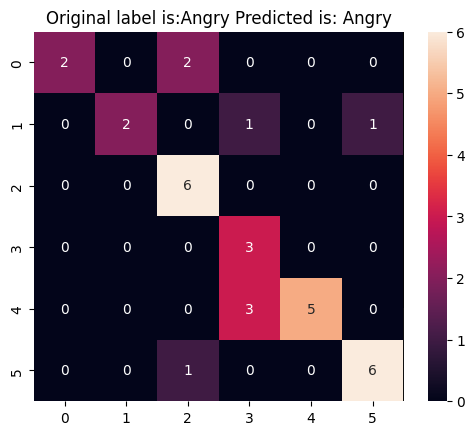

In [18]:
#Confusion Matrix - verify accuracy of each class

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, predictions)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']

n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

1/1 [==============================] - 0s 95ms/step


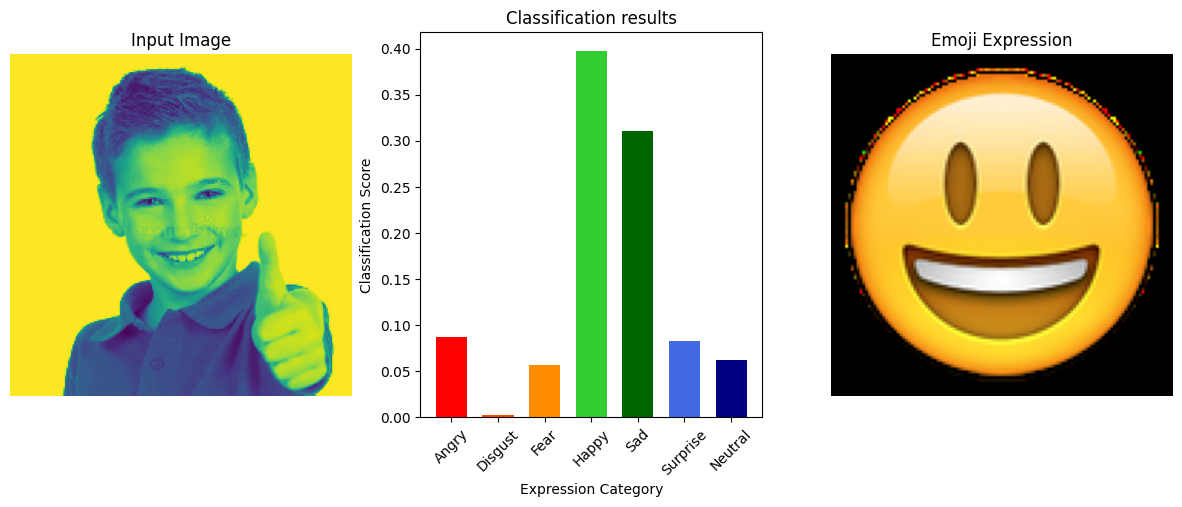

Predicted Emotion Class: 3
The Expression is Happy


In [39]:
from keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
import keras
import tensorflow as tf

# Load the pre-trained model
model = load_model('emotion_detection_model_100epochs.h5')

# Load and preprocess the image

img_path = 'happy-boy-showing-thumbs-up-gesture-27903653.webp'  
img = keras.utils.load_img(img_path, color_mode="grayscale", target_size=(224, 224))
img_array = img_to_array(img)
img_array /= 255.0 
img_array = np.expand_dims(img_array, axis=0)

# Make predictions

predictions = model.predict(img_array)
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
predicted_class = np.argmax(predictions)


fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Visualize the original image

axs[0].imshow(img)
axs[0].set_title('Input Image')
axs[0].axis('off')

# Visualize the classification results

ind = 0.1 + 0.6 * np.arange(len(emotion_labels))
width = 0.4
color_list = ['red', 'orangered', 'darkorange', 'limegreen', 'darkgreen', 'royalblue', 'navy']

for i in range(len(emotion_labels)):
    axs[1].bar(ind[i], predictions[0][i], width, color=color_list[i])

axs[1].set_title('Classification results')
axs[1].set_xlabel('Expression Category')
axs[1].set_ylabel('Classification Score')
axs[1].set_xticks(ind)
axs[1].set_xticklabels(emotion_labels, rotation=45)

# Visualize the predicted emoji

emoji_path = f'emojis/{emotion_labels[predicted_class]}.png'
emoji_img = keras.utils.load_img(emoji_path)
axs[2].imshow(emoji_img)
axs[2].set_title('Emoji Expression')
axs[2].axis('off')

output_dir = 'images/results/'
os.makedirs(output_dir, exist_ok=True)

plt.savefig(os.path.join(output_dir, 'keras_visualization.png'))
plt.show()
print("Predicted Emotion Class:", emotion_class)
print("The Expression is %s" % emotion_labels[predicted_class])
